# Experimental Results 1: SolarBatteryHouse

Here we run some experiments on the default version of the main Bauwerk environment, `SolarBatteryHouse`. For a full description of the environment, [see here](../../envs/solar_battery_house.ipynb). For work using this environment, we recommend rerunning these experiments as baselines.

<div class="alert alert-info">

Note

In this notebook Gym v0.21 is used, because this version is required for Stable Baselines3 (SB3), an RL algorithm library used here. Thus, the environment API is different compared to other pages in the Bauwerk docs.

</div>

## Evaluation

There is no one way that performance on the `SolarBatteryHouse` can or should be measured. One obvious choice would be to directly compare the cumulative reward, i.e. overall grid energy payments. However, the magnitude of this value completely depends on the configuration of the environment. Thus, this can make it difficult to compare performance between environments, even within Bauwerk. Instead, we propose using the access to the optimal control actions by considering *performance relative to random and optimal control*,

$p' = \frac{p_m-p_r}{p_o-p_r}$,

where $p_m$ is the average reward of the method to be evaluated, $p_r$ and $p_o$ the average rewards of random and optimal control respectively. 

<div class="alert alert-info">

Note

With the performance measure $p'$, a value $>0$ means that the method is better than random, a value close to $1$ means that the method is close to optimal, a value $<0$ means that the method is worse than random, i.e. completely useless.

</div>



## Baselines

### Random actions

Let's get started by establishing the lowest bar: what's the performance we get, when we just take random actions in the environment (sampled from the action space). To do this, we first need to determine how many actions in the environment we want to evaluate over (`EVAL_LEN`) and setup some helper code.

In [1]:
# Setup and helper code
import bauwerk
import gym
import numpy as np

EVAL_LEN = 24*30 # evaluate on 1 month of actions

# Create SolarBatteryHouse environment
env = gym.make("bauwerk/SolarBatteryHouse-v0")

def evaluate_actions(actions, env):
    cum_reward = 0
    obs = env.reset()
    for action in actions:
        obs, reward, done, info = env.step(np.array(action, dtype=np.float32))
        cum_reward += reward
    
    return cum_reward / len(actions)

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# mean random performance over 100 trials
random_trials = [evaluate_actions([env.action_space.sample() for _ in range(EVAL_LEN)], env) for _ in range(100)]
random_std = np.std(random_trials)
p_rand = np.mean(random_trials)
# note: std here is between different trials (of multiple actions)
print(f"Avg reward with random actions: {p_rand:.4f} (standard deviation: {random_std:.4f})")

Avg reward with random actions: -0.5479 (standard deviation: 0.0211)


### Optimal actions

`SolarBatteryHouse` is a fully tractable environment. Thus, Bauwerk can easily compute the theoretically optimal actions one can take in the environment.

In [3]:
optimal_actions, _ = bauwerk.solve(env)
p_opt = evaluate_actions(optimal_actions.reshape((-1,1))[:EVAL_LEN], env)
print(f"Avg reward (per step) with optimal actions: {p_opt:.4f}")

Avg reward (per step) with optimal actions: -0.1036


## RL agents

Next we consider simple reinforcement learning (RL) agents. We use [Stable Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) to access RL algorithm implementations. To begin, we look at a *Proximal Policy Optimisation*

In [4]:
from stable_baselines3 import PPO

NUM_TRAIN_STEP = 24 * 365

model_ppo = PPO(
    policy="MultiInputPolicy",
    env="bauwerk/SolarBatteryHouse-v0", 
    verbose=0,
)

In [5]:
# Helper functions for evaluating methods

from stable_baselines3.common.callbacks import BaseCallback

def eval_model(model, env):
    # Obtaining model actions and evaluating them
    model_actions = []
    obs = env.reset()
    for i in range(EVAL_LEN):
        action, _states = model.predict(obs)
        model_actions.append(action)
        obs, _, _, _ = env.step(action)

    p_model = evaluate_actions(model_actions[:EVAL_LEN], env)
    return p_model

# callback for evaluating callback during training
class EvalCallback(BaseCallback):
    def __init__(self, eval_freq = 24*7, verbose=0):
        super().__init__(verbose)
        self.data = []
        self.eval_freq = eval_freq
        self.eval_env = gym.make("bauwerk/SolarBatteryHouse-v0")

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.data.append(eval_model(self.model, self.eval_env))

    def _on_step(self) -> bool:
        if self.num_timesteps % self.eval_freq == 0:
            self.data.append(eval_model(self.model, self.eval_env))

        return True    

In [6]:
ppo_callback = EvalCallback()
model_ppo.learn(total_timesteps=NUM_TRAIN_STEP,callback=ppo_callback)

In [7]:
p_model_ppo = eval_model(model_ppo, env)
print(f"Avg reward (per step) with model actions: {p_model_ppo:.4f}")

Avg reward (per step) with model actions: -0.2680


In [8]:
# Measuring performance relative to random and optimal
def compute_rel_perf(p_model):
    return (p_model - p_rand)/(p_opt - p_rand)
p_rel_ppo = compute_rel_perf(p_model_ppo)
print(f"Performance relative to random and optimal: {p_rel_ppo:.4f}")

Performance relative to random and optimal: 0.6301


We see that the PPO agent we just trained is definitely outperforming random actions. How about another RL agent - SAC.

In [9]:
from stable_baselines3 import SAC

model_sac = SAC(
    policy="MultiInputPolicy",
    env="bauwerk/SolarBatteryHouse-v0", 
    verbose=0,
)
sac_callback = EvalCallback()
model_sac.learn(total_timesteps=NUM_TRAIN_STEP,callback=sac_callback)

p_model_sac = eval_model(model_sac, env)

print(f"Avg reward (per step) with model actions: {p_model_sac:.4f}")

p_rel_sac = compute_rel_perf(p_model_sac)
print(f"Performance relative to random and optimal: {p_rel_sac:.4f}")

Avg reward (per step) with model actions: -0.1497
Performance relative to random and optimal: 0.8962


Given the same amount of training time on the environment (1 year), SAC notably outperforms PPO.

## Results plot

Next we plot the combined results of the baselines, random and optimal actions, and our RL agents, PPO and SAC.

Text(0.5, 0, 'timesteps (each 1.0h)')

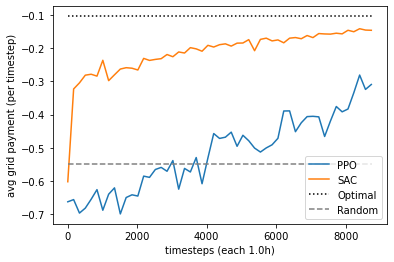

In [10]:
import matplotlib.pyplot as plt

x = np.arange(0,NUM_TRAIN_STEP,ppo_callback.eval_freq)
plt.plot(
    x, ppo_callback.data[:NUM_TRAIN_STEP//ppo_callback.eval_freq + 1], label="PPO"
)
plt.plot(
    x, sac_callback.data[:NUM_TRAIN_STEP//ppo_callback.eval_freq + 1], label="SAC"
)
plt.hlines(p_opt, 0, NUM_TRAIN_STEP, label="Optimal", linestyle=":", color="black")
plt.hlines(p_rand, 0, NUM_TRAIN_STEP, label="Random", linestyle="--", color="grey")
plt.legend()
plt.ylabel(f"avg grid payment (per timestep)")
plt.xlabel(f"timesteps (each {env.cfg.time_step_len}h)")

> Note for reproducibililty: this entire notebook was executed inside the devcontainer of the Bauwerk repository.